In [1]:
import cot_reports as cot
import pandas as pd
from pathlib import Path
import numpy as np
import MetaTrader5 as mt5

In [2]:
account_number = 23000710
password = 'Ze!0SFWkDnkCfN' 
server = 'ICMarketsAU-Demo'

print(f"Logging in to account {account_number} on server {server}...")

if mt5.initialize(login=account_number, server=server, password=password):
    print(f"Successfully logged in to account {account_number} on server {server}")

    # Your trading logic here, for example:
    account_info = mt5.account_info()
    if account_info is not None:
        print(account_info)
    else:
        print(f"Failed to get account info for account {account_number}")
        
else:
    print(f"Failed to log in to account {account_number} on server {server}: {mt5.last_error()}")

Logging in to account 23000710 on server ICMarketsAU-Demo...
Successfully logged in to account 23000710 on server ICMarketsAU-Demo
AccountInfo(login=23000710, trade_mode=0, leverage=30, limit_orders=200, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=10000.0, credit=0.0, profit=0.0, equity=10000.0, margin=0.0, margin_free=10000.0, margin_level=0.0, margin_so_call=100.0, margin_so_so=50.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Mark David De Paje', server='ICMarketsAU-Demo', currency='USD', company='International Capital Markets Pty. Ltd.')


In [3]:
def get_rates(pair1, timeframe, x):
    
    try:
        pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
        pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
        return pair1[['time','open', 'high', 'low', 'close']].set_index('time')
        
    except KeyError:
        print("Key Error")
        return None

### Carry

**Workflow**

1. Get factors
2. Estimation/fitting of factors 
3. Forecast under estimator from 2. 
3. Optimise forecasts for a risk-measure in the context of a portfolio returns
4. Optimise again for a risk measure for portfolio allocation 

factors to start with:

- rate differential, dollar index, CFTC net spec longs.
  - https://www.cbrates.com/decisions.htm (interest rates)
- yield data

In [4]:
data = Path("US Dollar Index Historical Data.csv")
DXY = pd.read_csv(data).iloc[::-1]
DXY['Date'] = pd.to_datetime(DXY['Date'], dayfirst = True)
DXY = DXY.set_index('Date')
DXY.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-01,96.39,96.50,97.10,96.39,NaN,0.00%
2020-01-02,96.85,96.48,96.87,96.42,NaN,0.48%
2020-01-03,96.84,96.79,97.11,96.71,NaN,-0.01%
2020-01-06,96.67,96.90,96.90,96.54,NaN,-0.18%
2020-01-07,97.00,96.65,97.09,96.62,NaN,0.34%


In [5]:
data = Path("United States 2-Year Bond Yield Historical Data.csv")
US2YR = pd.read_csv(data).iloc[::-1]
US2YR['Date'] = pd.to_datetime(US2YR['Date'], dayfirst = True)
US2YR = US2YR.set_index('Date')
US2YR.head()

,Price,Open,High,Low,Change %
Date,,,,,
2020-01-01,1.571,1.571,1.571,1.571,0.00%
2020-01-02,1.571,1.575,1.611,1.545,0.00%
2020-01-03,1.533,1.573,1.581,1.509,-2.44%
2020-01-06,1.547,1.515,1.561,1.511,0.91%
2020-01-07,1.538,1.547,1.556,1.532,-0.53%


In [6]:
data = Path("United States 5-Year Bond Yield Historical Data.csv")
US5YR = pd.read_csv(data).iloc[::-1]
US5YR['Date'] = pd.to_datetime(US5YR['Date'], dayfirst = True)
US5YR = US5YR.set_index('Date')
US5YR.head()

,Price,Open,High,Low,Change %
Date,,,,,
2020-01-01,1.693,1.693,1.693,1.693,0.00%
2020-01-02,1.666,1.697,1.715,1.634,-1.55%
2020-01-03,1.594,1.643,1.643,1.581,-4.32%
2020-01-06,1.607,1.568,1.620,1.560,0.81%
2020-01-07,1.604,1.611,1.622,1.594,-0.21%


In [7]:
data = Path("United States 10-Year Bond Yield Historical Data.csv")
US10YR = pd.read_csv(data).iloc[::-1]
US10YR['Date'] = pd.to_datetime(US10YR['Date'], dayfirst = True)
US10YR = US10YR.set_index('Date')
US10YR.head()

,Price,Open,High,Low,Change %
Date,,,,,
2020-01-01,1.921,1.921,1.921,1.921,0.09%
2020-01-02,1.877,1.919,1.946,1.851,-2.29%
2020-01-03,1.793,1.842,1.844,1.786,-4.46%
2020-01-06,1.809,1.769,1.816,1.760,0.88%
2020-01-07,1.811,1.813,1.828,1.795,0.10%


In [8]:
bond_dxy_data = { 'DXY' : DXY,
            '2YR': US2YR, 
             '5YR': US5YR,
             '10YR': US10YR }
bond_dxy_data.keys()

dict_keys(['DXY', '2YR', '5YR', '10YR'])

In [9]:
import pandas as pd
from datetime import datetime

# Define each central bank's data manually
rba_data = [
    ("May 20, 2025", 3.85),
    ("Feb 18, 2025", 4.10),
    ("Nov 07, 2023", 4.35),
    ("Jun 06, 2023", 4.10),
    ("May 02, 2023", 3.85),
    ("Mar 07, 2023", 3.60),
    ("Feb 07, 2023", 3.35),
    ("Dec 06, 2022", 3.10),
    ("Nov 01, 2022", 2.85),
    ("Oct 04, 2022", 2.60),
    ("Sep 06, 2022", 2.35),
    ("Aug 02, 2022", 1.85),
    ("Jul 05, 2022", 1.35),
    ("Jun 07, 2022", 0.85),
    ("May 03, 2022", 0.35),
    ("Nov 03, 2020", 0.10),
    ("Mar 19, 2020", 0.25),
    ("Mar 03, 2020", 0.50),
    ("Oct 01, 2019", 0.75),
]

ecb_data = [
    ("Jun 05, 2025", 2.15),
    ("Apr 17, 2025", 2.40),
    ("Mar 06, 2025", 2.65),
    ("Jan 30, 2025", 2.90),
    ("Dec 12, 2024", 3.15),
    ("Oct 17, 2024", 3.40),
    ("Sep 12, 2024", 3.65),
    ("Jun 06, 2024", 4.25),
    ("Sep 14, 2023", 4.50),
    ("Jul 27, 2023", 4.25),
    ("Jun 15, 2023", 4.00),
    ("May 04, 2023", 3.75),
    ("Mar 16, 2023", 3.50),
    ("Feb 02, 2023", 3.00),
    ("Dec 15, 2022", 2.50),
    ("Oct 27, 2022", 2.00),
    ("Sep 08, 2022", 1.25),
    ("Jul 21, 2022", 0.50),
    ("Mar 10, 2016", 0.00),
]

boe_data = [
    ("May 08, 2025", 4.25),
    ("Feb 06, 2025", 4.50),
    ("Nov 07, 2024", 4.75),
    ("Aug 01, 2024", 5.00),
    ("Aug 03, 2023", 5.25),
    ("Jun 22, 2023", 5.00),
    ("May 11, 2023", 4.50),
    ("Mar 23, 2023", 4.25),
    ("Feb 02, 2023", 4.00),
    ("Dec 15, 2022", 3.50),
    ("Nov 03, 2022", 3.00),
    ("Sep 22, 2022", 2.25),
    ("Aug 04, 2022", 1.75),
    ("Jun 16, 2022", 1.25),
    ("May 05, 2022", 1.00),
    ("Mar 17, 2022", 0.75),
    ("Feb 03, 2022", 0.50),
    ("Dec 16, 2021", 0.25),
    ("Mar 19, 2020", 0.10),
    ("Mar 11, 2020", 0.25),
    ("Aug 02, 2018", 0.75),
]

boj_data = [
    ("01-24-2025", 0.50),
    ("07-31-2024", 0.25),
    ("03-19-2024", 0.10),
    ("02-01-2016", -0.10),
]

boc_data = [
    ("03-12-2025", 2.75),
    ("01-29-2025", 3.00),
    ("12-11-2024", 3.25),
    ("10-23-2024", 3.75),
    ("09-04-2024", 4.25),
    ("07-24-2024", 4.50),
    ("06-05-2024", 4.75),
    ("07-12-2023", 5.00),
    ("06-07-2023", 4.75),
    ("01-25-2023", 4.50),
    ("12-07-2022", 4.25),
    ("10-26-2022", 3.75),
    ("09-07-2022", 3.25),
    ("07-13-2022", 2.50),
    ("06-01-2022", 1.50),
    ("04-13-2022", 1.00),
    ("03-02-2022", 0.50),
    ("03-27-2020", 0.25),
    ("03-13-2020", 0.75),
    ("03-04-2020", 1.25),
    ("10-24-2018", 1.75)
] 


snb_data = [
    ("2025-06-19", 0.00),
    ("2025-03-20", 0.25),
    ("2024-12-12", 0.50),
    ("2024-09-26", 1.00),
    ("2024-06-20", 1.25),
    ("2024-03-21", 1.50),
    ("2023-06-22", 1.75),
    ("2023-03-23", 1.50),
    ("2022-12-15", 1.00),
    ("2022-09-22", 0.50),
    ("2022-06-16", -0.25),
    ("2015-01-15", -0.75)
]

fed_data = [
    ("2024-12-18", 4.50),
    ("2024-11-07", 4.75),
    ("2024-09-19", 5.00),
    ("2023-07-26", 5.50),
    ("2023-05-03", 5.25),
    ("2023-03-22", 5.00),
    ("2023-02-01", 4.75),
    ("2022-12-14", 4.50),
    ("2022-11-02", 4.00),
    ("2022-09-21", 3.25),
    ("2022-07-28", 2.50),
    ("2022-06-15", 1.75),
    ("2022-05-04", 1.00),
    ("2022-03-16", 0.50),
    ("2020-03-15", 0.25),
    ("2020-03-03", 1.25),
    ("2019-10-30", 1.75)
]


# Convert to DataFrames
def create_filled_df(data, name):
    df = pd.DataFrame(data, columns=["Date", name])
    df["Date"] = pd.to_datetime(df["Date"], format = 'mixed')

    end_date = pd.to_datetime("2025-06-29")
    date_range = pd.date_range(start = df.index.min(), end = end_date, freq = 'D') 
    
    df = df.set_index("Date").sort_index()
    df = df.resample("D").ffill()

    df = df.reindex(date_range).ffill()
    
    return df.dropna()

rba_df = create_filled_df(rba_data, "RBA")
ecb_df = create_filled_df(ecb_data, "ECB")
boe_df = create_filled_df(boe_data, "BOE")
boj_df = create_filled_df(boj_data, "BOJ")
boc_df = create_filled_df(boc_data, "BOC")
snb_df = create_filled_df(snb_data, "CHF")
fed_df = create_filled_df(fed_data, "FED")


In [10]:
int_data = [rba_df, ecb_df, boe_df, boj_df, boc_df, snb_df, fed_df]

interest_rate_df = int_data[0]  # Start with rba_df
for df in int_data[1:]:  # Loop through the remaining dataframes
    interest_rate_df = interest_rate_df.join(df, how='outer')
    
interest_rate_df = interest_rate_df.sort_index().dropna()
interest_rate_df

,RBA,ECB,BOE,BOJ,BOC,CHF,FED
2019-10-30,0.75,0.00,0.75,-0.1,1.75,-0.75,1.75
2019-10-31,0.75,0.00,0.75,-0.1,1.75,-0.75,1.75
2019-11-01,0.75,0.00,0.75,-0.1,1.75,-0.75,1.75
2019-11-02,0.75,0.00,0.75,-0.1,1.75,-0.75,1.75
2019-11-03,0.75,0.00,0.75,-0.1,1.75,-0.75,1.75
...,...,...,...,...,...,...,...
2025-06-25,3.85,2.15,4.25,0.5,2.75,0.00,4.50
2025-06-26,3.85,2.15,4.25,0.5,2.75,0.00,4.50
2025-06-27,3.85,2.15,4.25,0.5,2.75,0.00,4.50
2025-06-28,3.85,2.15,4.25,0.5,2.75,0.00,4.50


In [11]:
# high-yield currencies -> AUD, NZD, CAD, GBP
# Low-yield currencies -> JPY, CHF, EUR

In [12]:
high_yield = ['AUD', 'USD', 'CAD', 'GBP']
low_yield = ['JPY', 'CHF', 'EUR']

In [13]:
from itertools import combinations
all_currencies = high_yield + low_yield
pairs = list(combinations(all_currencies, 2))

In [14]:
close_dfs = pd.DataFrame()

for pair in pairs:
    print(f"Iterating through {pair}")
    
    sym = pair[0] + pair[1] + '.a'
    print(sym)
    
    data = get_rates(sym, mt5.TIMEFRAME_D1, 600)
    
    if data is None:
        sym = pair[1] + pair[0] + '.a'
        data = get_rates(sym, mt5.TIMEFRAME_D1, 600) 
    
    data = data.rename(columns={'close': f'{sym}_close'})
    close_price = data[f'{sym}_close']
    close_dfs = pd.concat([close_dfs, close_price], axis = 1)

Iterating through ('AUD', 'USD')
AUDUSD.a
Iterating through ('AUD', 'CAD')
AUDCAD.a
Iterating through ('AUD', 'GBP')
AUDGBP.a
Key Error
Iterating through ('AUD', 'JPY')
AUDJPY.a
Iterating through ('AUD', 'CHF')
AUDCHF.a
Iterating through ('AUD', 'EUR')
AUDEUR.a
Key Error
Iterating through ('USD', 'CAD')
USDCAD.a
Iterating through ('USD', 'GBP')
USDGBP.a
Key Error
Iterating through ('USD', 'JPY')
USDJPY.a
Iterating through ('USD', 'CHF')
USDCHF.a
Iterating through ('USD', 'EUR')
USDEUR.a
Key Error
Iterating through ('CAD', 'GBP')
CADGBP.a
Key Error
Iterating through ('CAD', 'JPY')
CADJPY.a
Iterating through ('CAD', 'CHF')
CADCHF.a
Iterating through ('CAD', 'EUR')
CADEUR.a
Key Error
Iterating through ('GBP', 'JPY')
GBPJPY.a
Iterating through ('GBP', 'CHF')
GBPCHF.a
Iterating through ('GBP', 'EUR')
GBPEUR.a
Key Error
Iterating through ('JPY', 'CHF')
JPYCHF.a
Key Error
Iterating through ('JPY', 'EUR')
JPYEUR.a
Key Error
Iterating through ('CHF', 'EUR')
CHFEUR.a
Key Error


In [15]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("publicreporting.cftc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(publicreporting.cftc.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("jun7-fc8e", limit=5000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [16]:
interest_rate_df.tail()

,RBA,ECB,BOE,BOJ,BOC,CHF,FED
2025-06-25,3.85,2.15,4.25,0.5,2.75,0.0,4.5
2025-06-26,3.85,2.15,4.25,0.5,2.75,0.0,4.5
2025-06-27,3.85,2.15,4.25,0.5,2.75,0.0,4.5
2025-06-28,3.85,2.15,4.25,0.5,2.75,0.0,4.5
2025-06-29,3.85,2.15,4.25,0.5,2.75,0.0,4.5


In [18]:
combined.head()

NameError: name 'combined' is not defined

In [19]:
combined['Market and Exchange Names'].unique()

NameError: name 'combined' is not defined

In [20]:
bond_dxy_data.keys()

dict_keys(['DXY', '2YR', '5YR', '10YR'])

In [21]:
test_currencies = ['AUDUSD.a_close', 'GBPUSD.a_close', 'USDCAD.a_close'] 
test_pairs = close_dfs[test_currencies].dropna()
test_pairs.head()

,AUDUSD.a_close,GBPUSD.a_close,USDCAD.a_close
2023-03-21 00:00:00,0.66703,1.22173,1.37122
2023-03-22 00:00:00,0.66829,1.22683,1.37302
2023-03-23 00:00:00,0.66856,1.22868,1.37140
2023-03-24 00:00:00,0.66428,1.22295,1.37443
2023-03-27 00:00:00,0.66501,1.22877,1.36597


In [22]:
bond_dxy_df = pd.DataFrame()

for key in bond_dxy_data.keys():
    temp = bond_dxy_data[key]
    bond_dxy_df = pd.concat([bond_dxy_df, temp], axis = 1) 

In [23]:
bond_dxy_df

,Price,Open,High,Low,Vol.,Change %,Price,Open,High,Low,...,Price,Open,High,Low,Change %,Price,Open,High,Low,Change %
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,96.39,96.50,97.10,96.39,NaN,0.00%,1.571,1.571,1.571,1.571,...,1.693,1.693,1.693,1.693,0.00%,1.921,1.921,1.921,1.921,0.09%
2020-01-02,96.85,96.48,96.87,96.42,NaN,0.48%,1.571,1.575,1.611,1.545,...,1.666,1.697,1.715,1.634,-1.55%,1.877,1.919,1.946,1.851,-2.29%
2020-01-03,96.84,96.79,97.11,96.71,NaN,-0.01%,1.533,1.573,1.581,1.509,...,1.594,1.643,1.643,1.581,-4.32%,1.793,1.842,1.844,1.786,-4.46%
2020-01-06,96.67,96.90,96.90,96.54,NaN,-0.18%,1.547,1.515,1.561,1.511,...,1.607,1.568,1.620,1.560,0.81%,1.809,1.769,1.816,1.760,0.88%
2020-01-07,97.00,96.65,97.09,96.62,NaN,0.34%,1.538,1.547,1.556,1.532,...,1.604,1.611,1.622,1.594,-0.21%,1.811,1.813,1.828,1.795,0.10%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,98.94,99.20,99.23,98.82,0.00K,-0.25%,4.002,4.024,4.035,3.993,...,4.080,4.112,4.124,4.075,-0.92%,4.475,4.510,4.518,4.470,-0.66%
2025-06-10,99.04,98.98,99.39,98.86,NaN,0.10%,4.020,4.012,4.022,3.985,...,4.088,4.087,4.100,4.050,0.19%,4.473,4.480,4.490,4.438,-0.04%
2025-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.018,4.086,4.135,4.007,-1.72%,4.419,4.472,4.506,4.406,-1.20%


In [24]:
cot_sample = pd.read_csv('Legacy_-_Futures_Only_20250626.csv')
cot_sample['Market_and_Exchange_Names'].unique()

array(['UST 2Y NOTE - CHICAGO BOARD OF TRADE',
       'UST 5Y NOTE - CHICAGO BOARD OF TRADE',
       'GOLD - COMMODITY EXCHANGE INC.',
       'CANADIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE',
       'SWISS FRANC - CHICAGO MERCANTILE EXCHANGE',
       'BRITISH POUND - CHICAGO MERCANTILE EXCHANGE',
       'JAPANESE YEN - CHICAGO MERCANTILE EXCHANGE',
       'EURO FX - CHICAGO MERCANTILE EXCHANGE',
       'EURO FX/JAPANESE YEN XRATE - CHICAGO MERCANTILE EXCHANGE',
       'EURODOLLARS-3M - CHICAGO MERCANTILE EXCHANGE',
       'E-MINI S&P 500 - CHICAGO MERCANTILE EXCHANGE',
       'AUSTRALIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE',
       '2-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE',
       'U.S. TREASURY BONDS - MIDAMERICA COMMODITY EXCHANGE',
       '5-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE',
       'BRITISH POUND STERLING - CHICAGO MERCANTILE EXCHANGE',
       '3-MONTH EURODOLLARS - CHICAGO MERCANTILE EXCHANGE',
       'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EX

In [25]:
important_cot_columns = [
    'Report_Date_as_YYYY_MM_DD',           # Time index for weekly data
    'Market_and_Exchange_Names',           # Market (e.g., EUR/USD, Crude Oil)

    # Positioning (absolute)
    'NonComm_Positions_Long_All',
    'NonComm_Positions_Short_All',
    'Comm_Positions_Long_All',
    'Comm_Positions_Short_All',

    # Changes in positioning (momentum of sentiment)
    'Change_in_NonComm_Long_All',
    'Change_in_NonComm_Short_All',
    'Change_in_Comm_Long_All',
    'Change_in_Comm_Short_All',

    # Percent of Open Interest (for normalizing across time)
    'Pct_of_OI_NonComm_Long_All',
    'Pct_of_OI_NonComm_Short_All',
    'Pct_of_OI_Comm_Long_All',
    'Pct_of_OI_Comm_Short_All',

    # Open interest (can be used as volume proxy)
    'Open_Interest_All',
    'Change_in_Open_Interest_All'
]


In [26]:
UST_2Y_COT = cot_sample[cot_sample['Market_and_Exchange_Names'] == 'UST 2Y NOTE - CHICAGO BOARD OF TRADE']
UST_2Y_COT = UST_2Y_COT[important_cot_columns]
UST_2Y_COT['Report_Date_as_YYYY_MM_DD'] = pd.to_datetime(UST_2Y_COT[important_cot_columns]['Report_Date_as_YYYY_MM_DD'])
UST_2Y_COT = UST_2Y_COT.set_index('Report_Date_as_YYYY_MM_DD')
UST_2Y_COT = UST_2Y_COT.drop(columns = 'Market_and_Exchange_Names').shift(1)
UST_2Y_COT

C:\Users\markp\AppData\Local\Temp\ipykernel_5688\556963246.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  UST_2Y_COT['Report_Date_as_YYYY_MM_DD'] = pd.to_datetime(UST_2Y_COT[important_cot_columns]['Report_Date_as_YYYY_MM_DD'])


,NonComm_Positions_Long_All,NonComm_Positions_Short_All,Comm_Positions_Long_All,Comm_Positions_Short_All,Change_in_NonComm_Long_All,Change_in_NonComm_Short_All,Change_in_Comm_Long_All,Change_in_Comm_Short_All,Pct_of_OI_NonComm_Long_All,Pct_of_OI_NonComm_Short_All,Pct_of_OI_Comm_Long_All,Pct_of_OI_Comm_Short_All,Open_Interest_All,Change_in_Open_Interest_All
Report_Date_as_YYYY_MM_DD,,,,,,,,,,,,,,
2022-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-20,100196.0,458377.0,1720285.0,1284104.0,10973.0,42412.0,70184.0,46997.0,5.0,22.8,85.6,63.9,2008780.0,54353.0
2022-09-27,139358.0,481773.0,1688474.0,1250293.0,39162.0,23396.0,-31811.0,-33811.0,6.9,23.8,83.6,61.9,2020402.0,11622.0
2022-12-06,154887.0,474764.0,1671856.0,1246286.0,15529.0,-7009.0,-16618.0,-4007.0,7.6,23.4,82.4,61.4,2028931.0,8529.0
2022-10-11,171760.0,706300.0,1730674.0,1200781.0,15511.0,21873.0,30368.0,19991.0,8.1,33.5,82.0,56.9,2109988.0,10871.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-20,562762.0,1784994.0,3224121.0,2110695.0,12877.0,14316.0,4367.0,-35644.0,13.6,43.0,77.7,50.9,4149980.0,38477.0
2025-05-27,592294.0,1859625.0,3235687.0,2095301.0,29532.0,74631.0,11566.0,-15394.0,14.0,43.8,76.2,49.4,4244380.0,94400.0
2025-06-03,587637.0,1707540.0,2963237.0,2072248.0,-4657.0,-152085.0,-272450.0,-23053.0,14.6,42.5,73.7,51.5,4020344.0,-224036.0


### Stat Estimation

In [27]:
test_pairs.index = pd.to_datetime(test_pairs.index)
test_pairs.head()

,AUDUSD.a_close,GBPUSD.a_close,USDCAD.a_close
2023-03-21,0.66703,1.22173,1.37122
2023-03-22,0.66829,1.22683,1.37302
2023-03-23,0.66856,1.22868,1.37140
2023-03-24,0.66428,1.22295,1.37443
2023-03-27,0.66501,1.22877,1.36597


In [28]:
lst = [['RBA', 'FED'], ['BOE', 'FED'], ['FED', 'BOC']]
test_ir_df = pd.DataFrame()

for pair in lst:

    df = pd.DataFrame(interest_rate_df[pair[0]] - interest_rate_df[pair[1]]).rename(columns = {0: f'{pair[0], pair[1]} Differential'})
    test_ir_df = pd.concat([test_ir_df, df], axis = 1)

In [29]:
test_ir_df = test_ir_df.reindex(test_pairs.index)
test_ir_df

,"('RBA', 'FED') Differential","('BOE', 'FED') Differential","('FED', 'BOC') Differential"
2023-03-21,-1.15,-0.75,0.25
2023-03-22,-1.40,-1.00,0.50
2023-03-23,-1.40,-0.75,0.50
2023-03-24,-1.40,-0.75,0.50
2023-03-27,-1.40,-0.75,0.50
...,...,...,...
2025-06-23,-0.65,-0.25,1.75
2025-06-24,-0.65,-0.25,1.75
2025-06-25,-0.65,-0.25,1.75
2025-06-26,-0.65,-0.25,1.75


In [30]:
# interest_rate_df is prepped already
test_dxy = bond_dxy_data['DXY']
test_2YR = bond_dxy_data['2YR']

In [31]:
test_dxy = test_dxy.reindex(test_pairs.index)
test_2YR = test_2YR.reindex(test_pairs.index)

In [32]:
test_dxy = test_dxy[['Price', 'Change %']]
test_dxy.columns = 'DXY_Price', 'DXY_Change'
test_2YR = test_2YR[['Price', 'Change %']]
test_2YR.columns = '2YR_Price', '2YR_Change'

In [33]:
test_2YR['2YR_Change'] = test_2YR['2YR_Change'].str.rstrip('%').astype(float) / 100

In [34]:
test_dxy['DXY_Change'] = test_dxy['DXY_Change'].str.rstrip('%').astype(float) / 100

In [35]:
test_dxy.isna().sum()

DXY_Price     14
DXY_Change    14
dtype: int64

In [37]:
full_index = pd.date_range(start=UST_2Y_COT.index.min(), end=UST_2Y_COT.index.max(), freq='D')
test_UST_2Y_COT = UST_2Y_COT.reindex(full_index).ffill()
test_UST_2Y_COT.index.name = 'Date'
test_UST_2Y_COT = test_UST_2Y_COT.reindex(test_pairs.index)
test_UST_2Y_COT.head()

,NonComm_Positions_Long_All,NonComm_Positions_Short_All,Comm_Positions_Long_All,Comm_Positions_Short_All,Change_in_NonComm_Long_All,Change_in_NonComm_Short_All,Change_in_Comm_Long_All,Change_in_Comm_Short_All,Pct_of_OI_NonComm_Long_All,Pct_of_OI_NonComm_Short_All,Pct_of_OI_Comm_Long_All,Pct_of_OI_Comm_Short_All,Open_Interest_All,Change_in_Open_Interest_All
2023-03-21,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0
2023-03-22,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0
2023-03-23,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0
2023-03-24,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0
2023-03-27,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0


In [64]:
X_test_combined = pd.concat([test_dxy, test_UST_2Y_COT, test_ir_df], axis = 1).dropna()
print(f"NaN count is: {X_test_combined.isna().sum()}")

NaN count is: DXY_Price                      0
DXY_Change                     0
NonComm_Positions_Long_All     0
NonComm_Positions_Short_All    0
Comm_Positions_Long_All        0
Comm_Positions_Short_All       0
Change_in_NonComm_Long_All     0
Change_in_NonComm_Short_All    0
Change_in_Comm_Long_All        0
Change_in_Comm_Short_All       0
Pct_of_OI_NonComm_Long_All     0
Pct_of_OI_NonComm_Short_All    0
Pct_of_OI_Comm_Long_All        0
Pct_of_OI_Comm_Short_All       0
Open_Interest_All              0
Change_in_Open_Interest_All    0
('RBA', 'FED') Differential    0
('BOE', 'FED') Differential    0
('FED', 'BOC') Differential    0
dtype: int64


In [72]:
test_pairs = test_pairs.reindex(X_test_combined.index).dropna()
print(f"Test pairs length: {len(test_pairs)}")
print(f"Test X length: {len(X_test_combined)}")

Test pairs length: 576
Test X length: 576


<Axes: >

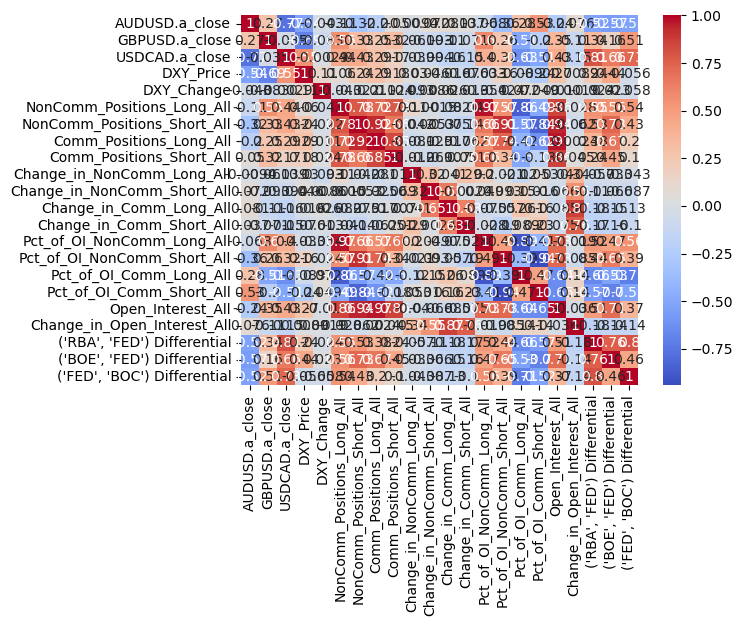

In [73]:
import seaborn as sns
combined = pd.concat([test_pairs, X_test_combined], axis = 1)
sns.heatmap(combined.corr(), annot = True, cmap = 'coolwarm')

In [74]:
X_test_combined_aug = np.hstack([np.ones((len(X_test_combined), 1)), 
                                         X_test_combined])

In [76]:
betas = np.linalg.lstsq(X_test_combined_aug, test_pairs, rcond=None)[0]

In [77]:
# Step 2: Calculate residuals
r_hat = X_test_combined_aug @ betas
residuals = test_pairs - r_hat
res_np = residuals.values
print(f"Residual NaN count is : {np.isnan(res_np).sum()}")

Residual NaN count is : 0


In [78]:
# Estimate residual covariance matrix Ψ (Psi)
Psi = np.cov(residuals.T)

In [79]:
X_test_combined_aug

array([[ 1.0000e+00,  1.0326e+02, -2.0000e-04, ..., -1.1500e+00,
        -7.5000e-01,  2.5000e-01],
       [ 1.0000e+00,  1.0235e+02, -8.8000e-03, ..., -1.4000e+00,
        -1.0000e+00,  5.0000e-01],
       [ 1.0000e+00,  1.0253e+02,  1.8000e-03, ..., -1.4000e+00,
        -7.5000e-01,  5.0000e-01],
       ...,
       [ 1.0000e+00,  9.9190e+01,  4.5000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00],
       [ 1.0000e+00,  9.8940e+01, -2.5000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00],
       [ 1.0000e+00,  9.9040e+01,  1.0000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00]])

In [80]:
Psi

array([[ 4.95470566e-05,  2.72499461e-05, -2.64535542e-05],
       [ 2.72499461e-05,  7.29000885e-05, -1.59668038e-05],
       [-2.64535542e-05, -1.59668038e-05,  5.04127156e-05]])

In [83]:
C

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

In [84]:
residuals

,AUDUSD.a_close,GBPUSD.a_close,USDCAD.a_close
2023-03-21,-0.008139,-0.005134,0.002692
2023-03-22,-0.002675,-0.003464,0.004995
2023-03-23,0.006725,-0.005014,-0.000262
2023-03-24,0.004811,-0.004643,-0.000846
2023-03-27,0.003920,-0.000681,-0.007640
...,...,...,...
2025-06-04,-0.004089,0.006231,-0.009530
2025-06-05,-0.002552,0.006862,-0.009801
2025-06-06,-0.001826,0.006885,-0.010271
2025-06-09,-0.000966,0.007396,-0.008539


In [105]:
# Step 4: Estimate matrix C (impact of X_t on the covariance matrix)
# Simplify: estimate via linear projection of residual variance on outer(X_t)
# Use only diagonal for simplification (no off-diagonal prediction)

# Number of explantory factors
K = len(X_test_combined.columns)
num_assets = 3

C = np.zeros((num_assets, K))

for i in range(num_assets):
    
    for k in range(K):
        
        # regress squared residuals of asset i on factor k
        C[i, k] = np.cov(res_np[:, i], X_test_combined_aug[:, k])[0, 1] / np.var(X_test_combined_aug[:, k])

C:\Users\markp\AppData\Local\Temp\ipykernel_5688\1635877164.py:16: RuntimeWarning: invalid value encountered in scalar divide
  C[i, k] = np.cov(res_np[:, i], X_test_combined_aug[:, k])[0, 1] / np.var(X_test_combined_aug[:, k])


In [107]:
EPS = 1e-10  # or 1e-12

for i in range(num_assets):
    for k in range(K):
        denom = np.var(X_test_combined_aug[:, k])
        if denom < EPS:
            C[i, k] = 0.0   # or np.nan if you want to skip it later
        else:
            cov_ik = np.cov(res_np[:, i], X_test_combined_aug[:, k])[0, 1]
            C[i, k] = cov_ik / denom

assert np.isfinite(C).all(), "Still got NaNs or Infs in C"


In [108]:
C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)

In [109]:
C

array([[ 0.00000000e+00, -2.94784399e-13,  1.82864167e-10,
        -1.42619293e-18, -2.14862080e-19, -1.36909143e-18,
        -3.63240569e-18,  2.02826730e-17,  1.11249830e-17,
         3.54952840e-18,  1.73770025e-18, -1.04253434e-14,
         7.44470921e-14, -7.80776269e-14, -1.39969037e-13,
        -7.24784468e-19,  6.34690950e-18,  4.58774279e-13,
        -3.04574685e-13],
       [ 0.00000000e+00,  6.61138434e-13, -2.54978640e-10,
         1.97756796e-17,  1.01419203e-17,  1.05779323e-17,
         1.56881792e-17, -2.67391032e-17, -4.10921824e-17,
        -2.48205052e-17, -9.80498991e-18,  8.24773730e-13,
         5.16979430e-13, -4.63455818e-13, -3.80868491e-13,
         7.03482904e-18, -2.29580125e-17,  2.59736743e-12,
         9.03360942e-12],
       [ 0.00000000e+00,  1.91913137e-14, -2.47211453e-11,
        -2.21639018e-18, -6.37894998e-19, -6.09490611e-20,
         1.76918977e-19, -3.76054626e-18, -3.14550264e-18,
         9.91007728e-19,  3.42484035e-18, -1.45481711e-13,
    

In [110]:
X_test_combined_aug

array([[ 1.0000e+00,  1.0326e+02, -2.0000e-04, ..., -1.1500e+00,
        -7.5000e-01,  2.5000e-01],
       [ 1.0000e+00,  1.0235e+02, -8.8000e-03, ..., -1.4000e+00,
        -1.0000e+00,  5.0000e-01],
       [ 1.0000e+00,  1.0253e+02,  1.8000e-03, ..., -1.4000e+00,
        -7.5000e-01,  5.0000e-01],
       ...,
       [ 1.0000e+00,  9.9190e+01,  4.5000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00],
       [ 1.0000e+00,  9.8940e+01, -2.5000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00],
       [ 1.0000e+00,  9.9040e+01,  1.0000e-03, ..., -6.5000e-01,
        -2.5000e-01,  1.7500e+00]])

In [111]:
X_test_combined.iloc[-1]

DXY_Price                           99.040
DXY_Change                           0.001
NonComm_Positions_Long_All      574694.000
NonComm_Positions_Short_All    1718619.000
Comm_Positions_Long_All        2957205.000
Comm_Positions_Short_All       1932689.000
Change_in_NonComm_Long_All      -12943.000
Change_in_NonComm_Short_All      11079.000
Change_in_Comm_Long_All          -6032.000
Change_in_Comm_Short_All       -139559.000
Pct_of_OI_NonComm_Long_All          15.000
Pct_of_OI_NonComm_Short_All         44.900
Pct_of_OI_Comm_Long_All             77.200
Pct_of_OI_Comm_Short_All            50.500
Open_Interest_All              3828810.000
Change_in_Open_Interest_All    -191534.000
('RBA', 'FED') Differential         -0.650
('BOE', 'FED') Differential         -0.250
('FED', 'BOC') Differential          1.750
Name: 2025-06-10 00:00:00, dtype: float64

In [112]:
# Step 5: Forecast next X_t+1 (simplified as last observation)
X_t_plus_1 = X_test_combined.iloc[-1]


In [113]:
# Step 5: Forecast next X_t+1 (simplified as last observation)
X_t_plus_1 = X_test_combined.iloc[-1]

# Step 6: Forecast conditional covariance matrix Σ_hat = Ψ + C X X' C'
C_matrix = C
X_outer = np.outer(X_t_plus_1, X_t_plus_1)
Sigma_hat = Psi + C_matrix @ X_outer @ C_matrix.T


In [114]:
pd.DataFrame(Sigma_hat)

,0,1,2
0,0.000050,0.000027,-0.000026
1,0.000027,0.000073,-0.000016
2,-0.000026,-0.000016,0.000050


In [115]:
D = np.sqrt(np.diag(Sigma_hat))
Corr = Sigma_hat / np.outer(D, D)
pd.DataFrame(Corr)

,0,1,2
0,1.000000,0.453036,-0.529274
1,0.453036,1.000000,-0.263307
2,-0.529274,-0.263307,1.000000


### Next Steps 

Backtest the effectiveness of the COV/CORR matrix in asset allocation. may need to backtest how correct it is first anyway to see if it's accurate or not anyway. y variable being cov/corr, x being the same explantory variables 

Other steps if the above isn't good right off the bat (which probably won't):
- pca of factors
- more factors pertaining 

C (factor loading matrix) stays constant. 

In [ ]:
# Step 5: Forecast next X_t+1 (simplified as last observation)
X_t_plus_1 = X_test_combined.iloc[-1]

# Step 6: Forecast conditional covariance matrix Σ_hat = Ψ + C X X' C'
C_matrix = C
X_outer = np.outer(X_t_plus_1, X_t_plus_1)
Sigma_hat = Psi + C_matrix @ X_outer @ C_matrix.T


In [ ]:
# Create function to get sigma_hat / correlation matrix for each line 

In [117]:
class get_vals():

    def __init__(self, X_test, C_matrix, Psi):
        self.X_test = X_test
        self.C_matrix = C
        self.psi = Psi

    def forecast_next_val(self, pos):
        self.X_t_plus_1 = self.X_test.iloc[pos]
        return self.X_t_plus_1
        
    def forecast_conditional_cov_matrix(self):
        self.X_outer =  np.outer(self.X_t_plus_1, self.X_t_plus_1)
        self.sig_hat = self.psi + self.C_matrix @ self.X_outer @ self.C_matrix.T
        return self.sig_hat
        

In [121]:
X_test_combined

,DXY_Price,DXY_Change,NonComm_Positions_Long_All,NonComm_Positions_Short_All,Comm_Positions_Long_All,Comm_Positions_Short_All,Change_in_NonComm_Long_All,Change_in_NonComm_Short_All,Change_in_Comm_Long_All,Change_in_Comm_Short_All,Pct_of_OI_NonComm_Long_All,Pct_of_OI_NonComm_Short_All,Pct_of_OI_Comm_Long_All,Pct_of_OI_Comm_Short_All,Open_Interest_All,Change_in_Open_Interest_All,"('RBA', 'FED') Differential","('BOE', 'FED') Differential","('FED', 'BOC') Differential"
2023-03-21,103.26,-0.0002,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0,-1.15,-0.75,0.25
2023-03-22,102.35,-0.0088,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0,-1.40,-1.00,0.50
2023-03-23,102.53,0.0018,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0,-1.40,-0.75,0.50
2023-03-24,103.12,0.0057,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0,-1.40,-0.75,0.50
2023-03-27,102.86,-0.0025,128135.0,659648.0,1965747.0,1455204.0,-112778.0,-199105.0,-87662.0,3129.0,5.5,28.1,83.7,61.9,2349950.0,-205318.0,-1.40,-0.75,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-04,98.79,-0.0044,587637.0,1707540.0,2963237.0,2072248.0,-4657.0,-152085.0,-272450.0,-23053.0,14.6,42.5,73.7,51.5,4020344.0,-224036.0,-0.65,-0.25,1.75
2025-06-05,98.74,-0.0005,587637.0,1707540.0,2963237.0,2072248.0,-4657.0,-152085.0,-272450.0,-23053.0,14.6,42.5,73.7,51.5,4020344.0,-224036.0,-0.65,-0.25,1.75
2025-06-06,99.19,0.0045,587637.0,1707540.0,2963237.0,2072248.0,-4657.0,-152085.0,-272450.0,-23053.0,14.6,42.5,73.7,51.5,4020344.0,-224036.0,-0.65,-0.25,1.75
2025-06-09,98.94,-0.0025,587637.0,1707540.0,2963237.0,2072248.0,-4657.0,-152085.0,-272450.0,-23053.0,14.6,42.5,73.7,51.5,4020344.0,-224036.0,-0.65,-0.25,1.75


In [123]:
obj = get_vals(X_test_combined, C_matrix, Psi)

num_days = len(X_test_combined)

for num in 
obj.forecast_next_val(3)

DXY_Price                      1.031200e+02
DXY_Change                     5.700000e-03
NonComm_Positions_Long_All     1.281350e+05
NonComm_Positions_Short_All    6.596480e+05
Comm_Positions_Long_All        1.965747e+06
Comm_Positions_Short_All       1.455204e+06
Change_in_NonComm_Long_All    -1.127780e+05
Change_in_NonComm_Short_All   -1.991050e+05
Change_in_Comm_Long_All       -8.766200e+04
Change_in_Comm_Short_All       3.129000e+03
Pct_of_OI_NonComm_Long_All     5.500000e+00
Pct_of_OI_NonComm_Short_All    2.810000e+01
Pct_of_OI_Comm_Long_All        8.370000e+01
Pct_of_OI_Comm_Short_All       6.190000e+01
Open_Interest_All              2.349950e+06
Change_in_Open_Interest_All   -2.053180e+05
('RBA', 'FED') Differential   -1.400000e+00
('BOE', 'FED') Differential   -7.500000e-01
('FED', 'BOC') Differential    5.000000e-01
Name: 2023-03-24 00:00:00, dtype: float64

### baseline

In [67]:
# Simulate 4 currency returns (r_t) over 125 days
T, N = 125, 4  # T: time, N: assets
r_t = np.random.normal(0, 0.01, size=(T, N))

# FACTORS # 
# Simulate 3 observable factors (X_t) over 125 days
K = 3  # K: number of explanatory factors
X_t = np.random.normal(0, 1, size=(T, K))

# Step 1: Estimate mean returns alpha and factor loadings beta using OLS
X_t_augmented = np.hstack([np.ones((T, 1)), X_t])  # add intercept
betas = np.linalg.lstsq(X_t_augmented, r_t, rcond=None)[0]  # shape (K+1, N) 

# Step 2: Calculate residuals
r_hat = X_t_augmented @ betas
residuals = r_t - r_hat

# Step 3: Estimate residual covariance matrix Ψ (Psi)
Psi = np.cov(residuals.T)

# Step 4: Estimate matrix C (impact of X_t on the covariance matrix)
# Simplify: estimate via linear projection of residual variance on outer(X_t)
# Use only diagonal for simplification (no off-diagonal prediction)

C = np.zeros((N, K))
for i in range(N):
    for k in range(K):
        # regress squared residuals of asset i on factor k
        C[i, k] = np.cov(residuals[:, i], X_t[:, k])[0, 1] / np.var(X_t[:, k])

# Step 5: Forecast next X_t+1 (simplified as last observation)
X_t_plus_1 = X_t[-1]

# Step 6: Forecast conditional covariance matrix Σ_hat = Ψ + C X X' C'
C_matrix = C
X_outer = np.outer(X_t_plus_1, X_t_plus_1)
Sigma_hat = Psi + C_matrix @ X_outer @ C_matrix.T


In [69]:
Sigma_hat

array([[ 8.31989057e-05, -1.38555912e-06, -3.32826119e-06,
         8.26731514e-06],
       [-1.38555912e-06,  9.06697003e-05,  4.98079224e-06,
         1.67720729e-05],
       [-3.32826119e-06,  4.98079224e-06,  1.13033410e-04,
         2.74937957e-06],
       [ 8.26731514e-06,  1.67720729e-05,  2.74937957e-06,
         9.38770087e-05]])

### Value

- EER Data
- Excess Return

In [124]:
urls = ["https://stats.bis.org/api/v2/data/dataflow/BIS/WS_EER/1.0/D.N.N.BE+CA+CH+DE+FR+GB+IT+JP+NL+SE+US?startPeriod=2020-01-01&endPeriod=2025-06-13&format=csv"] 
df = pd.concat([pd.read_csv(url) for url in urls])

In [126]:
df = df[df['FREQ'] == 'D']
df = df[['FREQ', 'EER_TYPE', 'EER_BASKET', 'REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']].dropna()
df.head()

,FREQ,EER_TYPE,EER_BASKET,REF_AREA,TIME_PERIOD,OBS_VALUE
0,D,N,N,CH,2020-01-01,97.83
1,D,N,N,CH,2020-01-02,97.65
2,D,N,N,CH,2020-01-03,97.76
5,D,N,N,CH,2020-01-06,97.81
6,D,N,N,CH,2020-01-07,97.77


In [127]:
df['REF_AREA'].unique()

array(['CH', 'CA', 'BE', 'FR', 'GB', 'DE', 'NL', 'JP', 'IT', 'US', 'SE'],
      dtype=object)

In [26]:
df['TIME_PERIOD']

3680      1983-10-03
3681      1983-10-04
3682      1983-10-05
3683      1983-10-06
3684      1983-10-07
             ...    
146543    2025-05-30
146544    2025-05-31
146545    2025-06-01
146546    2025-06-02
146547    2025-06-03
Name: TIME_PERIOD, Length: 136980, dtype: object

In [42]:
au_vals = df[df['REF_AREA'] == 'AU'].dropna()
au_vals = au_vals[['TIME_PERIOD', 'OBS_VALUE']]
au_vals['TIME_PERIOD'] = pd.to_datetime(au_vals['TIME_PERIOD'])
au_vals = au_vals.set_index('TIME_PERIOD')
au_vals

,OBS_VALUE
TIME_PERIOD,
1983-10-03,169.69
1983-10-04,170.10
1983-10-05,170.55
1983-10-06,171.61
1983-10-07,171.27
...,...
2025-05-28,98.42
2025-05-29,98.62
2025-05-30,98.14


In [81]:
from pathlib import Path
data = Path('AUDUSD_historical_data.csv')
audusd = pd.read_csv(data)
audusd['Date'] = pd.to_datetime(audusd['Date'])
audusd = audusd.set_index('Date')
audusd_eer = pd.concat([audusd, au_vals], axis = 1).dropna()
audusd_eer['OBS_VALUE_shifted'] = audusd_eer['OBS_VALUE'].shift(-20)
audusd_eer.dropna()

,Open,High,Low,Close,Change(Pips),Change(%),OBS_VALUE,OBS_VALUE_shifted
2023-02-10,0.69386,0.69600,0.68599,0.68980,-40.6,-0.59,106.43,102.99
2023-02-13,0.69073,0.69740,0.69030,0.69682,60.9,0.87,106.95,103.03
2023-02-14,0.69683,0.70294,0.68701,0.69868,18.5,0.26,107.09,103.39
2023-02-15,0.69869,0.69873,0.68630,0.69063,-80.6,-1.17,106.38,103.23
2023-02-16,0.69063,0.69362,0.68370,0.68620,-44.3,-0.65,106.60,103.20
...,...,...,...,...,...,...,...,...
2025-04-30,0.63871,0.64179,0.63552,0.64100,22.9,0.36,98.10,98.42
2025-05-01,0.64098,0.64267,0.63655,0.63851,-24.7,-0.39,98.11,98.62
2025-05-02,0.63854,0.64699,0.63817,0.64436,58.2,0.90,98.72,98.14
2025-05-05,0.64436,0.64939,0.64341,0.64609,17.3,0.27,99.06,98.64


In [82]:
from scipy.stats import chi2_contingency

table = pd.crosstab(audusd_eer['Change(Pips)'], audusd_eer['OBS_VALUE_shifted'])
chi2, pval, dof, expected = chi2_contingency(table)
print(pval)

0.0006440077290139184


In [85]:
rng = np.random.RandomState(42)
n_samples = 200
X = rng.rand(n_samples, 2)                          # 2 features
true_coef = np.array([3.0, -2.0])                   # ground truth
y = X @ true_coef + rng.normal(scale=0.2, size=n_samples)

In [133]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 2) Generate synthetic data
X = audusd_eer[['OBS_VALUE_shifted']].dropna()
y = audusd_eer[['Change(%)']].dropna()
y = y.iloc[-len(X):]

In [134]:
# 3) Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [135]:

# 4) Fit the model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [136]:

# 5) Evaluate on test data
y_pred = model.predict(X_test)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R² on test:", r2_score(y_test, y_pred))
print("RMSE on test:", mean_squared_error(y_test, y_pred, squared=False))

# 6) Predict on new data
new_obs = np.array([[0.4, 0.8]])
print("Prediction for", new_obs, "→", model.predict(new_obs))



Intercept: [-0.00271714]
Coefficients: [[-0.00059467]]
R² on test: -0.01442125546985773
RMSE on test: 0.581526065772409


C:\Users\markp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\markp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but LinearRegression is expecting 1 features as input.

In [138]:
pred_vs_real = pd.concat([pd.DataFrame(y_pred), pd.DataFrame(y_test).reset_index()], axis = 1)[[0, 'Change(%)']]
pred_vs_real

,0,Change(%)
0,-0.065687,-0.29
1,-0.065782,-0.51
2,-0.064617,-0.73
3,-0.065259,1.06
4,-0.063624,1.12
...,...,...
112,-0.062238,-0.01
113,-0.065033,-0.21
114,-0.062779,-0.49
115,-0.065431,-0.11


<Axes: >

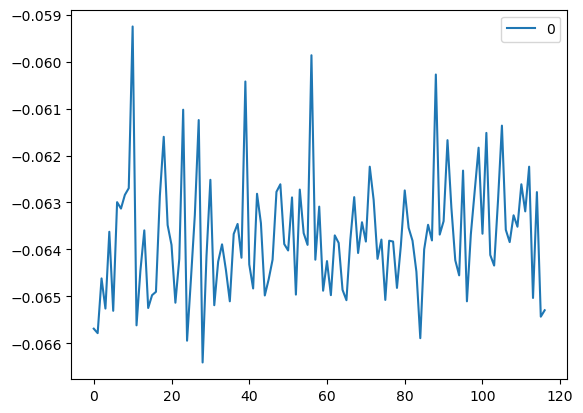

In [139]:
pd.DataFrame(y_pred).plot()

In [122]:
pd.DataFrame(y_test)

,Change(Pips)
2024-07-19,-19.5
2024-10-01,-35.4
2023-07-14,-50.1
2024-09-24,73.2
2024-03-20,73.7
...,...
2025-03-03,-0.7
2024-05-10,-13.9
2023-10-31,-31.3
2024-05-21,-7.6


### Momentum